# LoL 데이터로 분석해보기

[League of Legends Ranked Matches ](https://www.kaggle.com/paololol/league-of-legends-ranked-matches)

[Document URL](https://github.com/slundberg/shap/blob/master/notebooks/tree_explainer/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.ipynb)

* `dependence_plot` , `summary_plot` , `force_plot`

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt


In [11]:
shap.initjs()

In [13]:
prefix = "./shap_data/"

matches = pd.read_csv(prefix+"matches.csv")
participants = pd.read_csv(prefix+"participants.csv")
stats1 = pd.read_csv(prefix+"stats1.csv", low_memory=False)
stats2 = pd.read_csv(prefix+"stats2.csv", low_memory=False)
stats = pd.concat([stats1,stats2])


In [18]:
# merge into a single DataFrame
a = pd.merge(participants, matches, left_on="matchid", right_on="id")
allstats_orig = pd.merge(a, stats, left_on="matchid", right_on="id")
allstats = allstats_orig.copy()

# drop games that lasted less than 10 minutes
allstats = allstats.loc[allstats["duration"] >= 10*60,:]


In [19]:
cat_cols = ["role", "position", "version", "platformid"]
for c in cat_cols:
    allstats[c] = allstats[c].astype('category')
    allstats[c] = allstats[c].cat.codes
allstats["wardsbought"] = allstats["wardsbought"].astype(np.int32)

X = allstats.drop(["win"], axis=1)
y = allstats["win"]


In [20]:
rate_features = [
    "kills", "deaths", "assists", "killingsprees", "doublekills",
    "triplekills", "quadrakills", "pentakills", "legendarykills",
    "totdmgdealt", "magicdmgdealt", "physicaldmgdealt", "truedmgdealt",
    "totdmgtochamp", "magicdmgtochamp", "physdmgtochamp", "truedmgtochamp",
    "totheal", "totunitshealed", "dmgtoobj", "timecc", "totdmgtaken",
    "magicdmgtaken" , "physdmgtaken", "truedmgtaken", "goldearned", "goldspent",
    "totminionskilled", "neutralminionskilled", "ownjunglekills",
    "enemyjunglekills", "totcctimedealt", "pinksbought", "wardsbought",
    "wardsplaced", "wardskilled"
]
for feature_name in rate_features:
    X[feature_name] /= X["duration"] / 60 # per minute rate

# convert to fraction of game
X["longesttimespentliving"] /= X["duration"]

In [22]:
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingsprees": "Killing sprees per min.",
    "longesttimespentliving": "Longest time living as % of game",
    "doublekills": "Double kills per min.",
    "triplekills": "Triple kills per min.",
    "quadrakills": "Quadra kills per min.",
    "pentakills": "Penta kills per min.",
    "legendarykills": "Legendary kills per min.",
    "totdmgdealt": "Total damage dealt per min.",
    "magicdmgdealt": "Magic damage dealt per min.",
    "physicaldmgdealt": "Physical damage dealt per min.",
    "truedmgdealt": "True damage dealt per min.",
    "totdmgtochamp": "Total damage to champions per min.",
    "magicdmgtochamp": "Magic damage to champions per min.",
    "physdmgtochamp": "Physical damage to champions per min.",
    "truedmgtochamp": "True damage to champions per min.",
    "totheal": "Total healing per min.",
    "totunitshealed": "Total units healed per min.",
    "dmgtoobj": "Damage to objects per min.",
    "timecc": "Time spent with crown control per min.",
    "totdmgtaken": "Total damage taken per min.",
    "magicdmgtaken": "Magic damage taken per min.",
    "physdmgtaken": "Physical damage taken per min.",
    "truedmgtaken": "True damage taken per min.",
    "goldearned": "Gold earned per min.",
    "goldspent": "Gold spent per min.",
    "totminionskilled": "Total minions killed per min.",
    "neutralminionskilled": "Neutral minions killed per min.",
    "ownjunglekills": "Own jungle kills per min.",
    "enemyjunglekills": "Enemy jungle kills per min.",
    "totcctimedealt": "Total crown control time dealt per min.",
    "pinksbought": "Pink wards bought per min.",
    "wardsbought": "Wards bought per min.",
    "wardsplaced": "Wards placed per min.",
    "turretkills": "# of turret kills",
    "inhibkills": "# of inhibitor kills",
    "dmgtoturrets": "Damage to turrets"
}
feature_names = [full_names.get(n, n) for n in X.columns]
X.columns = feature_names

# create train/validation split
Xt, Xv, yt, yv = train_test_split(X,y, test_size=0.2, random_state=10)
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)


In [29]:

params = {
    "eta": 0.5,
    "max_depth": 4,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss" ,
    "nthread " : 10
}
model = xgb.train(params, dt, 300, [(dt, "train"),(dv, "valid")], early_stopping_rounds=5, verbose_eval=25)

[0]	train-logloss:0.54138	valid-logloss:0.541355
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 5 rounds.
[25]	train-logloss:0.286261	valid-logloss:0.286604
[50]	train-logloss:0.252087	valid-logloss:0.253618
[75]	train-logloss:0.23394	valid-logloss:0.236235
[100]	train-logloss:0.221312	valid-logloss:0.224341
[125]	train-logloss:0.21213	valid-logloss:0.215961
[150]	train-logloss:0.203073	valid-logloss:0.207636
[175]	train-logloss:0.196033	valid-logloss:0.20114
[200]	train-logloss:0.190072	valid-logloss:0.19573
[225]	train-logloss:0.183624	valid-logloss:0.189536
[250]	train-logloss:0.178362	valid-logloss:0.184558
[275]	train-logloss:0.172688	valid-logloss:0.179285
[299]	train-logloss:0.167593	valid-logloss:0.174458


# xgb 모델 설명
* 수천의 샘플들을 shap value로 바꿔줄 수 있다. 

In [31]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

In [39]:
explainer.expected_value

0.016130319

## 한 선수가 특정 경기에서 이기는 것을 설명하는 것
* `SHAP VALUE` 는  아래와 같는 방법으로 만들어진다.
    * 모델의 기대 값과 현재 선수의 결과값의 차이를 더한다.
    * Tree SHAP 에서만 가능하다 
    * 모델에서 SHAP VALUE의 단위들은 `log odds ratios`이다.
    * 큰 값이 나올수록 이길 것 같다는 것이다 음수로 크게 나올 수록 진다는 것이다.

```
# make sure the SHAP values add up to marginal predictions
pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

```

In [47]:
shap.force_plot(explainer.expected_value, shap_values[0,:], Xv.iloc[0,:])

## 아래는 3명을 동시에 했을 때 해봤는데, 의미 파악이 어렵다...

In [48]:
shap.force_plot(explainer.expected_value, shap_values[0:3,:], Xv.iloc[0:3,:])

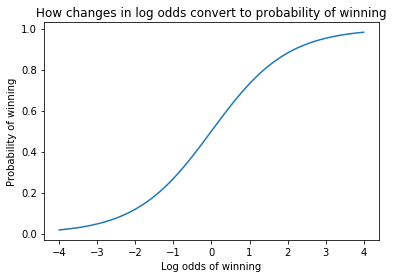

In [50]:
xs = np.linspace(-4,4,100)
plt.xlabel("Log odds of winning")
plt.ylabel("Probability of winning")
plt.title("How changes in log odds convert to probability of winning")
plt.plot(xs, 1/(1+np.exp(-xs)))
plt.show()

## 전체 데이터셋에 대한 모든 Feature들의 영향을 요약하는 법
* `summary_plot` 
* 특정 예측의 feature에 대한 SHAP 값은 model feature가 해당 feature를 관찰 할 때 변경되는 정도를 나타냅니다.
* 한 row마다 한 feature에 대한 shap 값이다. 그 shap value 값은 모델의 승리시의 log odds 입니다.
* 모든 feature 에서 봄으로써, 어떤 것이 영향을 주는지 볼 수 있다. 

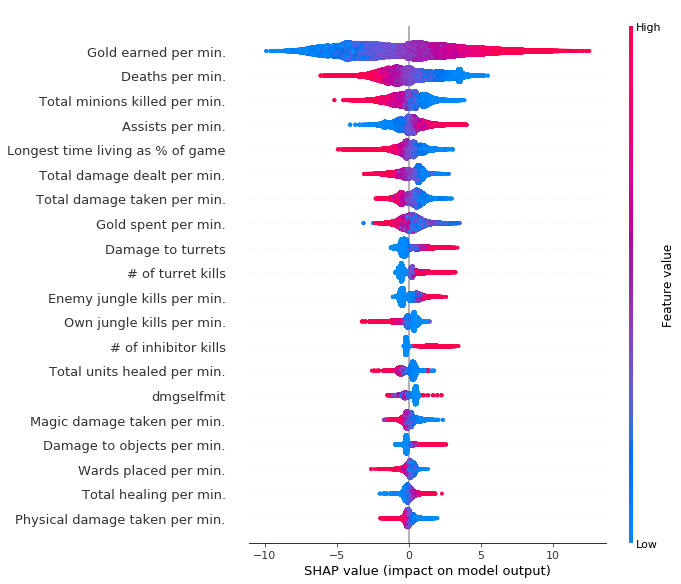

In [51]:
shap.summary_plot(shap_values, Xv)

## Examine how changes in a feature change the model's prediction

* 실제로 xgboost는 매우 복잡한 모델입니다. 그러나 shap plotting 함으로써, 우리는 모델의 결과가 feature value에 어떻게 변화하는지 알 수 있습니다.
* 이것과 유사한 plot이 `dependence plot`입니다. 
    * 뿐만 아니라 `iteraction term` 이 얼마나 영향을 주는지도 볼 수 있습니다.
    * 수직선의 분산을 봄으로써 얼마나 영향을 미치는 지 알 수 있습니다.
    * 한가지 예로 gold/min을 보자. 만약 500/min 을 벌면 vertical 이 퍼지는 정도가 좁아질 것이다. 이 의미는 500/min 보다 적게 버는 player 보다, 더 많이 버는 player는 다른 변수들에 덜 영향을 받는 다는 의미다.
    * y-axis 변수의 shap 값을 표현  
  

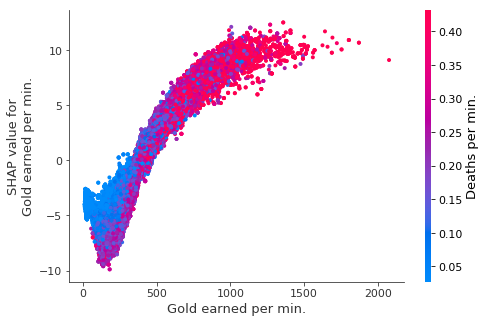

In [52]:
shap.dependence_plot("Gold earned per min.", 
                     shap_values, Xv, 
                     interaction_index="Deaths per min.")

In [55]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))
top_inds

array([56, 25, 60, 26, 30, 36, 52, 57, 49, 58, 63, 62, 59, 46, 47, 53, 48,
       68, 45, 54, 38, 41, 64, 55, 65, 24, 27, 29, 13,  0, 69, 43, 39, 44,
       37, 21, 18, 17, 61, 22, 42, 19, 50, 66, 40, 20, 31, 23,  9, 14, 32,
       70, 15, 67, 33, 28, 11, 10, 34,  1,  2,  3,  4,  7,  6, 51,  8, 12,
       16,  5, 35])

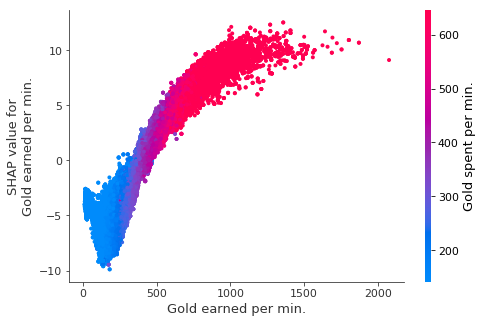

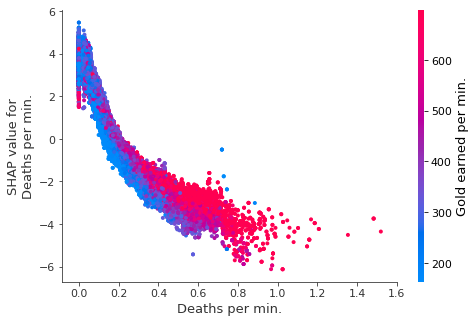

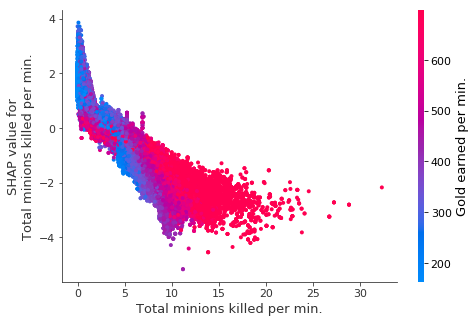

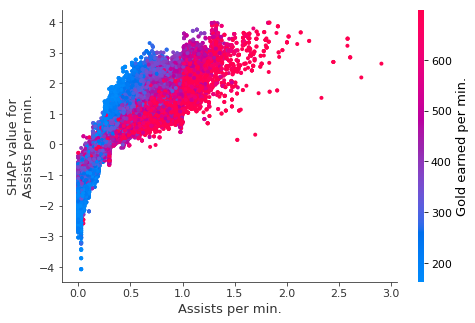

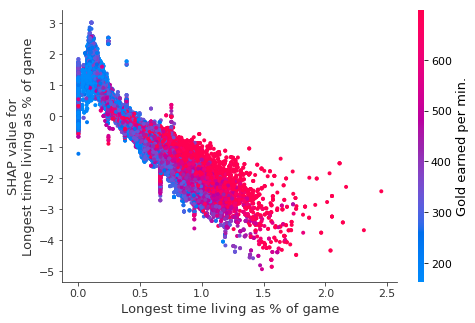

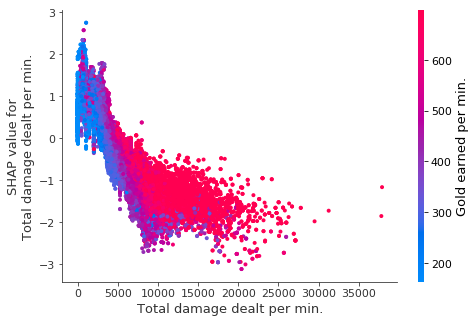

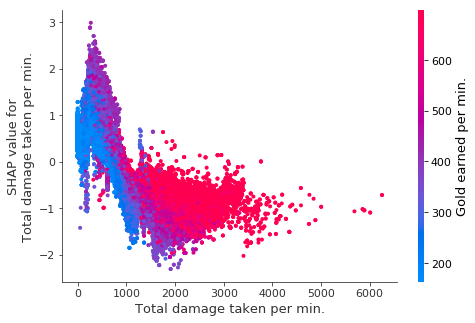

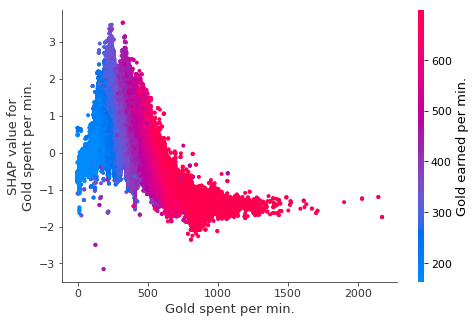

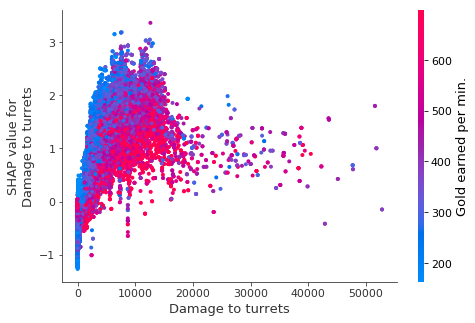

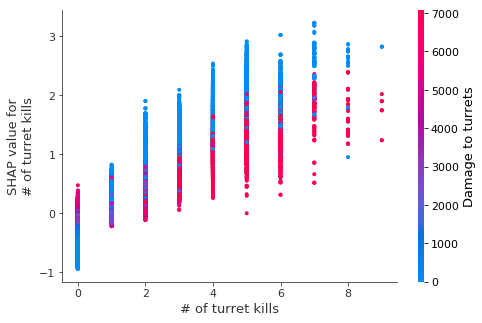

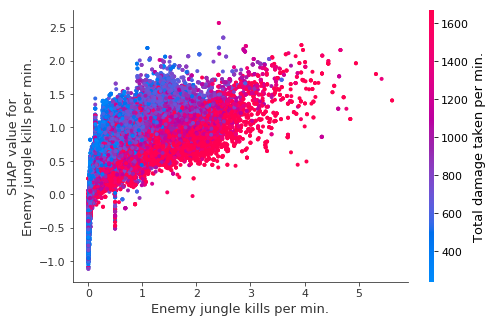

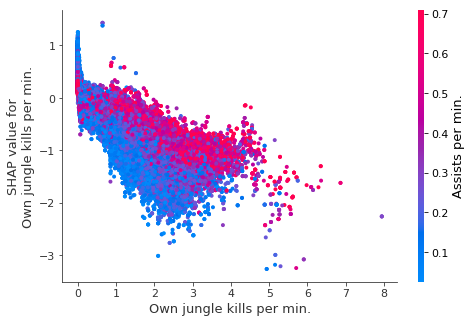

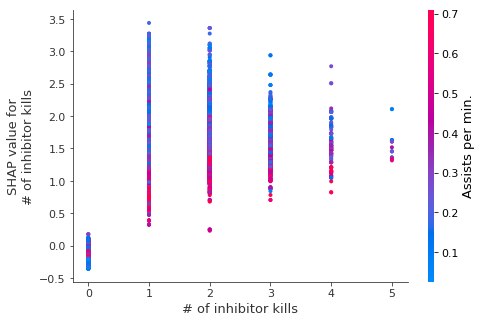

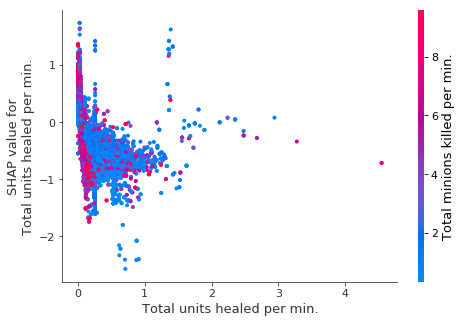

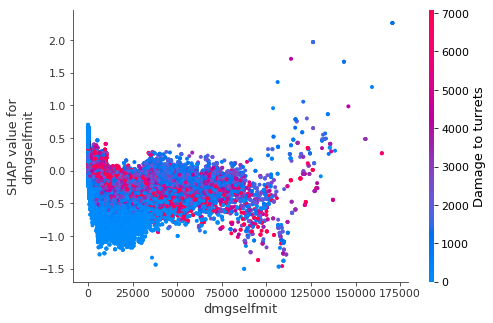

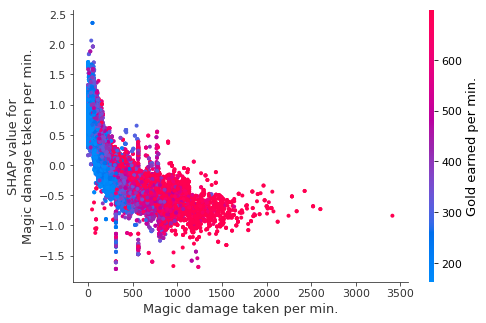

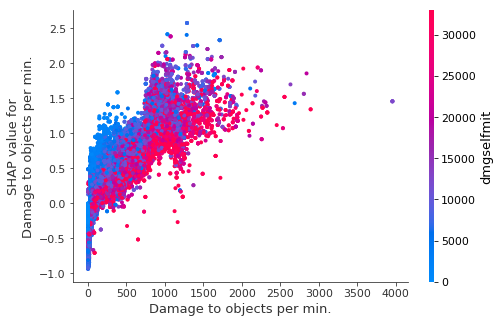

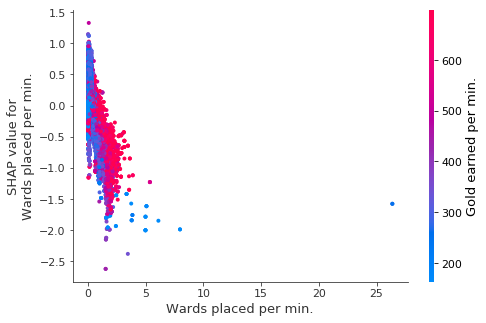

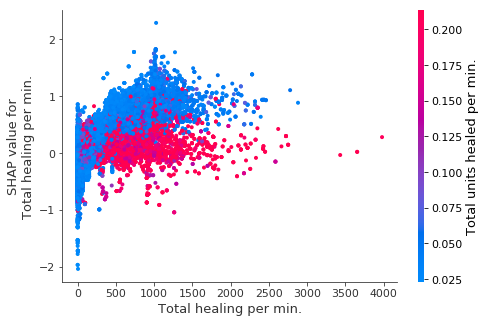

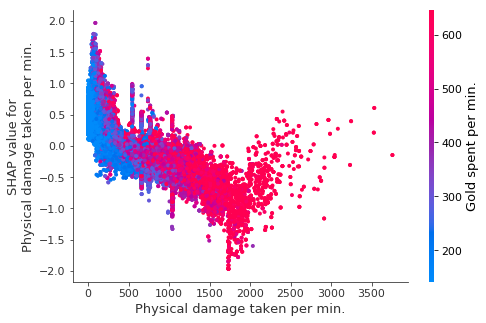

In [53]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values, Xv)